In [4]:
import argparse
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gap_filling.data_handler import DataHandler
from gap_filling.edgar_projection import ProjectData
from gap_filling.fill_gaps import fill_all_sector_gaps, prepare_df
from gap_filling.utils import (parse_and_format_data_to_insert, get_all_edgar_data, get_all_faostat_data, get_all_ceds_data, generate_carbon_equivalencies,
                               assemble_data)
from gap_filling.constants import get_gap_equations, get_sectors


# def process_all(args, new_db):
############################
# Get the data
############################
# Init the Data Handler


# get connections
get_ceds_conn = DataHandler()




In [5]:
#Get CEDS data
ceds_data = get_all_ceds_data(get_ceds_conn)
#Convert column names to strings for processing
ceds_data.columns = ceds_data.columns.astype(str)

#Now ensure all ceds and edgar values are numpy floats
for yr in range(2015,2023):
    ceds_data[str(yr)] = ceds_data[str(yr)].astype(float)


In [6]:
ceds_data.loc[(ceds_data['Gas'] == "ch4") & (ceds_data["Sector"] == '1A2d_Ind-Comb-Pulp-paper')]['2020'].sum()

36764.9824262966

In [7]:
gas = "CO2"

In [8]:
df = pd.read_csv(f"./gap_filling/data/{gas.upper()}_annual_1A2e_2H2_emissions_in_kt.csv.csv")
df.replace(to_replace=["NE", "NO", "IE", "NA", "NO,IE"], value=np.nan, inplace=True)

df.Sector = df.Sector.astype(str).str.strip()
df = df[df["Party"] != 'European Union (Convention)']

df.dropna().reset_index(drop=True, inplace=True)

In [9]:

def plot_annex1_sectors(df, sec1, sec2):
    df_subset = df[df['Sector'].isin([sec1, sec2])]

    df_pivot = df_subset.pivot(index="Party", columns="Sector").dropna(how='all')

    fig,ax = plt.subplots(figsize=(8,6))

    colors = plt.cm.get_cmap('tab10', len(df["Party"].unique()))
    color_map = {country: colors(i) for i, country in enumerate(df["Party"].unique())}

    valid_x_vals = []
    valid_y_vals = []

    for country in df_pivot.index:
        first = True
        for yr in df_pivot.columns.levels[0]:
            valid_data = df_pivot.loc[country][yr].dropna()
            try:
                if first:
                    plt.scatter(float(valid_data[sec1]), float(valid_data[sec2]), c=color_map[country], label=country)
                    first=False
                else:
                    plt.scatter(float(valid_data[sec1]), float(valid_data[sec2]), c=color_map[country] )
                valid_x_vals.append(float(valid_data[sec1]))
                valid_y_vals.append(float(valid_data[sec2]))
            except:
                pass
        # plt.scatter(df_pivot.loc[country, :][sec1], df_pivot.loc[country, :][sec2], label=country)

    plt.xlabel(f'{sec1} kt/yr')
    plt.ylabel(f'{sec2} kt/yr')

    plt.legend(title='Country')
    plt.title(f'{gas.upper()} emissions')
    plt.show()
    return valid_x_vals, valid_y_vals

import scipy.stats as st


def ratio_analysis_histogram(ratios):
    fig,ax = plt.subplots(figsize=(8,6))
    plt.hist(ratios,bins=100)
    plt.xlabel(f"{sec2.split('  ')[0]} / {sec1.split('  ')[0]}")
    plt.ylabel("count")
    plt.text(0.75, 0.75, f'median={np.nanmedian(ratios):.3f} kt/kt\nmean={np.nanmean(ratios):.3f} kt/kt',
            transform=ax.transAxes)
    plt.title(f'{gas.upper()} emission ratios')
    plt.show()

    return np.median(ratios), np.nanmean(ratios)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

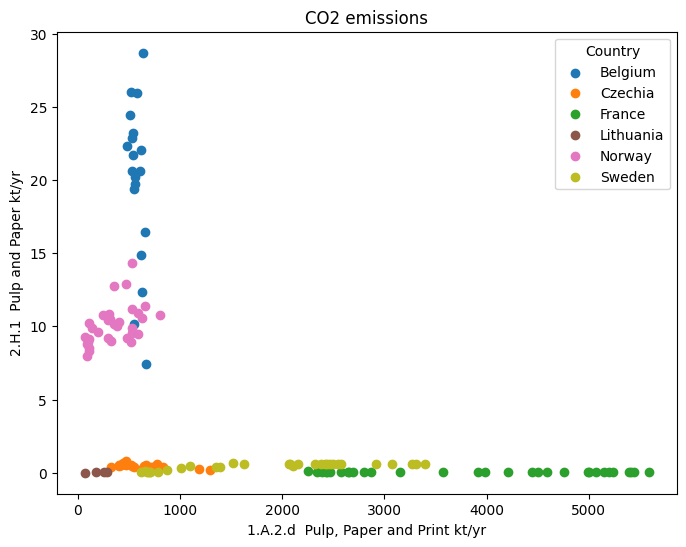

(array([0.00055966]), array([11246.78107987]), 1, array([25901.52790528]))


/var/folders/m6/jjnlxlvd1cg27ft29fy02vcr0000gn/T/ipykernel_1422/3326809896.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reg = np.linalg.lstsq(np.array(valid_x_vals)[:, np.newaxis], np.array(valid_y_vals))


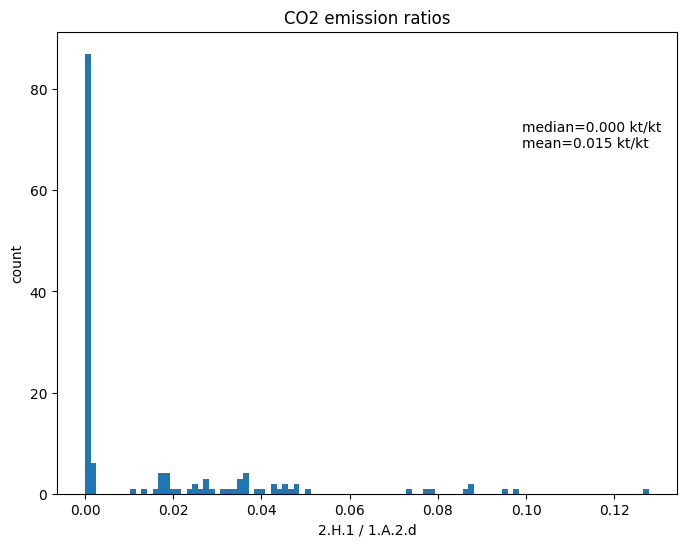

Global CO2 1.A.2.d emissions from CEDS: 115421 kt
Global CO2 2.H.1 estimate using median: 51 kt
Global CO2 2.H.1 estimate using mean: 1698 kt
Global CO2 2.H.1 estimate using the regression slope: 65 kt


In [10]:
# sec1 = '1.A.2.e  Food Processing, Beverages and Tobacco'
# sec2 = '2.H.2  Food and Beverages Industry'
sec1 = '1.A.2.d  Pulp, Paper and Print'
sec2 = '2.H.1  Pulp and Paper'
valid_x_vals, valid_y_vals = plot_annex1_sectors(df, sec1, sec2)

#Linalg.lstsq forces the intercept through 0
reg = np.linalg.lstsq(np.array(valid_x_vals)[:, np.newaxis], np.array(valid_y_vals))
print(reg)# returns slope, residuals, rank of matrix, singular values
ratios = [y/x for x,y in zip(valid_x_vals,valid_y_vals)]

ratio_analysis_histogram(ratios)

sel = (ceds_data.Sector == "1A2d_Ind-Comb-Pulp-paper") & (ceds_data.Gas == gas.lower())
ceds_1a2d = ceds_data.loc[sel, "2022"]

print(f'Global {gas.upper()} 1.A.2.d emissions from CEDS: {ceds_1a2d.sum()/1000:.0f} kt')
print(f'Global {gas.upper()} 2.H.1 estimate using median: {ceds_1a2d.sum() * np.nanmedian(ratios)/1000:.0f} kt')
print(f'Global {gas.upper()} 2.H.1 estimate using mean: {ceds_1a2d.sum() * np.nanmean(ratios)/1000:.0f} kt')
print(f'Global {gas.upper()} 2.H.1 estimate using the regression slope: {ceds_1a2d.sum() * reg[0][0]/1000:.0f} kt')



In [11]:
ceds_data.loc[(ceds_data['Gas'] == "ch4") & (ceds_data["Sector"] == '1A2d_Ind-Comb-Pulp-paper')]['2020'].sum()

36764.9824262966

In [12]:
sel = (ceds_data.Sector == "1A2d_Ind-Comb-Pulp-paper") & (ceds_data.Gas == 'ch4')
ceds_1a2d = ceds_data.loc[sel, "2020"]
ceds_1a2d.sum()

36764.9824262966

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

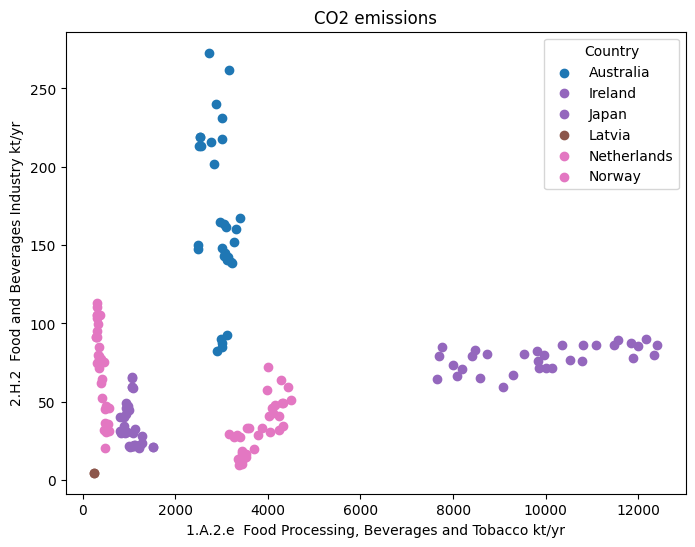

(array([0.01159432]), array([891853.38841668]), 1, array([63429.71472428]))


/var/folders/m6/jjnlxlvd1cg27ft29fy02vcr0000gn/T/ipykernel_1422/2831816018.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  reg = np.linalg.lstsq(np.array(valid_x_vals)[:, np.newaxis], np.array(valid_y_vals))


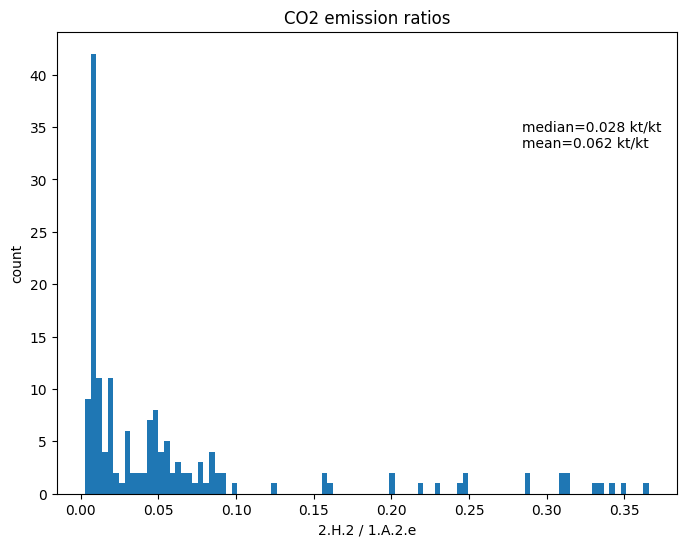

Global CO2 1.A.2.e emissions from CEDS: 205044 kt
Global CO2 2.H.2 estimate using median: 5804 kt
Global CO2 2.H.2 estimate using mean: 12625 kt
Global CO2 2.H.2 estimate using the regression slope: 2377 kt


In [13]:
sec1 = '1.A.2.e  Food Processing, Beverages and Tobacco'
sec2 = '2.H.2  Food and Beverages Industry'

valid_x_vals, valid_y_vals = plot_annex1_sectors(df, sec1, sec2)

#Linalg.lstsq forces the intercept through 0
reg = np.linalg.lstsq(np.array(valid_x_vals)[:, np.newaxis], np.array(valid_y_vals))
print(reg)# returns slope, residuals, rank of matrix, singular values
ratios = [y/x for x,y in zip(valid_x_vals,valid_y_vals)]

ratio_analysis_histogram(ratios)

sel = (ceds_data.Sector == "1A2e_Ind-Comb-Food-tobacco") & (ceds_data.Gas == gas.lower())
ceds_1a2e = ceds_data.loc[sel, "2022"]
print(f'Global {gas.upper()} 1.A.2.e emissions from CEDS: {ceds_1a2e.sum()/1000:.0f} kt')
print(f'Global {gas.upper()} 2.H.2 estimate using median: {ceds_1a2e.sum() * np.nanmedian(ratios)/1000:.0f} kt')
print(f'Global {gas.upper()} 2.H.2 estimate using mean: {ceds_1a2e.sum() * np.nanmean(ratios)/1000:.0f} kt')
print(f'Global {gas.upper()} 2.H.2 estimate using the regression slope: {ceds_1a2e.sum() * reg[0][0]/1000:.0f} kt')

Per conversation with Lekha, we will assume the following emissions for these sectors:
 - For 2.H.1 pulp and paper direct emissions: assume 0 emissions for all countries
 - For 1.A.2.d combustion related emissions from pulp and paper industry: use CEDS country-level estimates
 - For 2.H.2 food-beverage-tobacco direct emissions: use relationship between 2.H.2 and 1.A.2.e emissions reported for the 6 Annex I countries represented in the graph below (take slope or median ratio for country-specific relationship) and scale 1.A.2.e emissions for those 6 countries to estimate 2.H.2 emissions
 - 2.H.2 emissions for all other countries assumed to be 0
 - 1.A.2.e combustion related emissions from food-bev-tobacco: use CEDS country-level estimates

So, the only things we need then are:
1.  to calculate the country-specific relationship between the 1.A.2.e and 2.H.2 emissions for countries that reported both, 
2. quantify the scaling factor (i.e. slope or mean) and 
3. multiply this by the CEDS 1.A.2.e emissions to estimate 2.H.2 emissions

In [14]:
#First, let's define a function for quantifying the relationship between country-level 
# 1.A.2.e emissions and 2.H.2 emissions

# def country_level_emission_relationship(df, country, sec1, sec2):


    # return

In [15]:

def quantify_country_scaling_factor(df, sec1, sec2, country, show_plots=True):
    import scipy.stats as st

    sel = (df['Sector'].isin([sec1, sec2])) & (df["Party"] == country)
    subset_df = df.loc[sel,:]
    sec1_vals = subset_df.loc[subset_df.Sector==sec1, np.arange(1990,2022).astype(str)].values.flatten().astype(float)
    sec2_vals = subset_df.loc[subset_df.Sector==sec2, np.arange(1990,2022).astype(str)].values.flatten().astype(float)

    nan_mask = np.argwhere((~np.isnan((sec1_vals))) & (~np.isnan(sec2_vals))).flatten()
    
    if show_plots:
        plt.scatter(sec1_vals[nan_mask], sec2_vals[nan_mask])

    #Conduct regression
    reg = st.linregress(sec1_vals[nan_mask], sec2_vals[nan_mask])

    #If negative or pvalue<0.1: take mean ratio OR fewer than 3 points, otherwise take slope
    if reg.slope > 0 and reg.pvalue < 0.1 and len(sec1_vals[nan_mask]) > 4:
        factor = reg.slope
        method = 'slope'
    else:
        factor = np.nanmean(sec2_vals[nan_mask] / sec1_vals[nan_mask])
        method = 'mean_ratio'

    if show_plots:
        plt.plot(np.linspace(np.nanmin(sec1_vals) * 0.9, np.nanmax(sec1_vals) * 1.1, 10), 
                np.linspace(np.nanmin(sec1_vals) * 0.9, np.nanmax(sec1_vals) * 1.1, 10) * reg.slope + reg.intercept,
                '--')


        plt.xlabel(f'{sec1} kt/yr')
        plt.ylabel(f'{sec2} kt/yr')

        plt.title(f'{gas.upper()} emissions')
        plt.show()

    return factor, method



In [16]:
sec1 = '1.A.2.e  Food Processing, Beverages and Tobacco'
sec2 = '2.H.2  Food and Beverages Industry'

scaling_factor_dict = {}
countries = ["Australia", "Ireland", "Japan", "Latvia", "Netherlands", "Norway"]
for country in countries:
    scaling_factor_dict[country] = quantify_country_scaling_factor(df, sec1, sec2, country, show_plots=False)

In [17]:
scaling_factor_dict

{'Australia': (0.058027985893698814, 'mean_ratio'),
 'Ireland': (0.03456180041126286, 'mean_ratio'),
 'Japan': (0.00301252616930371, 'slope'),
 'Latvia': (0.019653376364036128, 'mean_ratio'),
 'Netherlands': (0.030652299226139684, 'slope'),
 'Norway': (0.2010591615063445, 'mean_ratio')}

In [18]:
#Now multiply these by the CEDS 1.A.2.e data to estimate 2.H.2 emissions:
#2.H.2-food-beverage-tobacco-direct

iso3_dict = {
    "Australia": "AUS",
    "Ireland": "IRL",
    "Japan": "JPN",
    "Latvia": "LVA",
    "Netherlands": "NLD",
    "Norway": "NOR"
}

#First get country code for each relevant country
country_code = [iso3_dict[c] for c in countries]

#Next, get subset of ceds data with those countries and 1.A.2.e sector
sel = (ceds_data["ID"].isin(country_code)) & (ceds_data["Sector"] == "1A2e_Ind-Comb-Food-tobacco") & \
    (ceds_data["Gas"] == "co2")

sector_ceds_df = ceds_data.loc[sel]
for col in np.arange(2015,2023).astype(str):
    for country in countries:
        sel_new = (sel) & (ceds_data["ID"] == iso3_dict[country])
        sector_ceds_df.loc[sel_new, col] *= scaling_factor_dict[country][0]

food_bev_direct = sector_ceds_df.copy()

Make it more functional and run as a standalone:

In [22]:
def calculate_scaling_factors(df):

    sec1 = '1.A.2.e  Food Processing, Beverages and Tobacco'
    sec2 = '2.H.2  Food and Beverages Industry'

    scaling_factor_dict = {}
    countries = ["Australia", "Ireland", "Japan", "Latvia", "Netherlands", "Norway"]
    for country in countries:
        scaling_factor_dict[country] = quantify_country_scaling_factor(df, sec1, sec2, country, show_plots=False)
    
    iso3_dict = {
        "Australia": "AUS",
        "Ireland": "IRL",
        "Japan": "JPN",
        "Latvia": "LVA",
        "Netherlands": "NLD",
        "Norway": "NOR"
    }

    #First get country code for each relevant country
    country_code = [iso3_dict[c] for c in countries]

    sf_df = pd.DataFrame({
        "ID": country_code,
        "2H2_per_1A2e": [scaling_factor_dict[c][0] for c in countries]
    })
    sf_df.to_csv('gap_filling/data/2H2_per_1A2e_AnnexI_scaling_factors.csv')
    
    return sf_df

In [28]:
new_db = False
# get connection
get_ceds_conn = DataHandler()
#Get CEDS data
ceds_data = get_all_ceds_data(get_ceds_conn)
#Convert column names to strings for processing
ceds_data.columns = ceds_data.columns.astype(str)
#Now ensure all ceds and edgar values are numpy floats
for yr in range(2015,2023):
    ceds_data[str(yr)] = ceds_data[str(yr)].astype(float)

#Get AnnexI data
df = pd.read_csv(f"./gap_filling/data/CO2_annual_1A2e_2H2_emissions_in_kt.csv")
df.replace(to_replace=["NE", "NO", "IE", "NA", "NO,IE"], value=np.nan, inplace=True)
df.Sector = df.Sector.astype(str).str.strip()
df = df[df["Party"] != 'European Union (Convention)']
df.dropna().reset_index(drop=True, inplace=True)

#Calculate scaling factors
sf_df = calculate_scaling_factors(df)

#Next, get subset of ceds data with those countries and 1.A.2.e sector
sel = (ceds_data["ID"].isin(sf_df["ID"].values)) & (ceds_data["Sector"] == "1A2e_Ind-Comb-Food-tobacco") & \
    (ceds_data["Gas"] == "co2")

#Scale 1A2e data by country-specific scaling factors and send back the dataframe
sector_ceds_df = ceds_data.loc[sel]
for col in np.arange(2015,2023).astype(str):
    for iso in sf_df["ID"].values:
        sel_new = (sel) & (ceds_data["ID"] == iso)
        sector_ceds_df.loc[sel_new, col] *= sf_df.loc[sf_df["ID"] == iso, "2H2_per_1A2e"].values[0]